<a href="https://colab.research.google.com/github/anaiy2004/African-American-Police-Killings-Classifier/blob/master/PoliceKillingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Download and Pre-Processing from [Mapping Police Violence]("https://static1.squarespace.com/static/54ecf211e4b0ed744420c5b6/t/5f04cebda843400a2e8bacd4/1594150600757/MPVDatasetDownload.xlsx")





In [1]:
#installing useful libraries
!pip install xlrd   
!pip install psycopg2

In [2]:
#importing useful libraries
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import psycopg2 as ps

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
#url of download
url = "https://static1.squarespace.com/static/54ecf211e4b0ed744420c5b6/t/5f3d421e5256010f80e9c7b9/1597850143670/MPVDatasetDownload.xlsx"

In [4]:
#creates a dataframe by reading in url with columns = column_names
column_names = ["Victims name" ,  "VictimsAge" , "VictimsGender" , "VictimsRace", "URL of image" , "Date of Incident", "Street" , "City" , "State" , "Zipcode" , "County" , "Agency", "Strange", "CauseOfDeath" , "description" , "disposition" , "CriminalCharges" , "link" , "MentalIllness" , "Armed" , "AllegedWeapon" , "AllegedThreatLevel" , "Fleeing" , "BodyCam", "WaPO ID"  , "Offduty" , "Geo" , "ID"]
df  = pd.read_excel(url, "2013-2020 Police Killings", header=None, names = column_names)
df = df.iloc[1:]
df.head()

,Victims name,VictimsAge,VictimsGender,VictimsRace,URL of image,Date of Incident,Street,City,State,Zipcode,County,Agency,Strange,CauseOfDeath,description,disposition,CriminalCharges,link,MentalIllness,Armed,AllegedWeapon,AllegedThreatLevel,Fleeing,BodyCam,WaPO ID,Offduty,Geo,ID
1,Kevin Lee Catlett,62,Male,Unknown race,NaN,2020-06-30 00:00:00,900 McArthur Street,Johnson City,TN,37601,Washington,Johnson City Department,TN0900100,Gunshot,"About 7 p.m., Johnson City police were respond...",Pending investigation,No known charges,https://wcyb.com/news/local/officer-involved-s...,Drug or alcohol use,Allegedly Armed,gun,attack,NaN,NaN,NaN,NaN,Suburban,8267
2,Nick Costales,34,Male,Hispanic,https://fatalencounters.org/wp-content/uploads...,2020-06-29 00:00:00,9501 Monte Vista Ave,Montclair,CA,91763,San Bernardino,"Pomona Police Department, California Highway P...",CA0195500;CA0349900,Gunshot,Nick Costales was wanted for murdering his mot...,Pending investigation,No known charges,https://kmph.com/news/local/fresno-murder-susp...,No,Allegedly Armed,gun,attack,NaN,NaN,NaN,NaN,Suburban,8263
3,Wade Russell Meisberger,48,Male,White,https://fatalencounters.org/wp-content/uploads...,2020-06-29 00:00:00,West Beech St and South Church St,Hazleton,PA,18201,Luzerne,"Pennsylvania State Police, U.S. Marshals Service",PAPSPAB00;US Marshals,Gunshot,Wade Russell Meisberger was the passenger insi...,Pending investigation,No known charges,https://www.pahomepage.com/top-stories/police-...,No,Allegedly Armed,gun,attack,Car,No,5958,NaN,Urban,8264
4,Brittany S. Teichroeb,26,Female,White,NaN,2020-06-29 00:00:00,TX-191 and TX-250 Loop,Midland,TX,79706,Midland,"Texas Department of Public Safety, U.S. Marsha...",TX0000000;US Marshals,Gunshot,Troopers were assisting U.S. deputy marshals i...,Pending investigation,No known charges,https://www.yourbasin.com/news/local-news/deta...,No,Allegedly Armed,gun,NaN,NaN,NaN,NaN,NaN,Rural,8265
5,John Parks,57,Male,White,https://fatalencounters.org/wp-content/uploads...,2020-06-29 00:00:00,Court Avenue and Audubon Drive,Paducah,KY,42001,McCracken,McCracken County Sheriff's Office,KY0730000,Gunshot,"John Parks, 57, was shot and killed just befor...",Pending investigation,No known charges,https://www.kentucky.com/news/local/crime/arti...,No,Unclear,undetermined,undetermined,Car,No,5953,NaN,Suburban,8266


In [5]:
#deleting unnecesary information
df = df.drop(columns=['Victims name' , 'Strange', 'City', 'URL of image', 'County' , "AllegedThreatLevel", 'Street', 'Date of Incident' , "Offduty", 'Zipcode' , 'Geo', 'Agency' , 'description' , 'disposition' , 'link' , 'WaPO ID' , 'ID' ])


In [6]:
#deleting unclear data and null values
df = df[df.VictimsRace != "Unknown Race"]
df = df[df.MentalIllness != "Unknown"]
df = df[df.AllegedWeapon != "unclear"]
df = df[df.AllegedWeapon != "unknown weapon"]
df = df[df.AllegedWeapon != "undetermined"]
df = df[df.Fleeing != "Other"]
df = df.dropna()
df.head()

,VictimsAge,VictimsGender,VictimsRace,State,CauseOfDeath,CriminalCharges,MentalIllness,Armed,AllegedWeapon,Fleeing,BodyCam
3,48,Male,White,PA,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
6,68,Male,White,OH,Gunshot,No known charges,Yes,Allegedly Armed,gun,Not fleeing,No
12,30,Male,White,NV,Gunshot,No known charges,Drug or alcohol use,Allegedly Armed,gun,Foot,No
13,38,Male,White,IN,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
17,27,Male,White,FL,Gunshot,No known charges,No,Allegedly Armed,gun,Not fleeing,No


In [7]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#creates a one-hot encoder function which returns a column of our dataframe one-hot encodeded as well as their categorical name (given input of the column) 

def one_hot_encode(data):
  values = array(data)
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  shape = onehot_encoded.shape
  inverted = []
  for i in range(shape[-1]):
      inverted.append(label_encoder.inverse_transform([i]))
  return onehot_encoded, inverted



In [8]:
# declares output array
outputs = [[] for i in range(len(df))] 

In [9]:
#creates inputs [1,0] = African American Killing by Police, [0,1] = non African American Killing by Police
races = df["VictimsRace"] 
count = 0
for race in races:
  if(race == "Black"):
    outputs[count].append(1)
    outputs[count].append(0)
  else:
    outputs[count].append(0)
    outputs[count].append(1)
  count += 1
df = df.drop(columns = "VictimsRace")

In [10]:
df = df.drop(columns="VictimsAge")
df.head()
#shows the input dataframe before it is one-hot encoded

,VictimsGender,State,CauseOfDeath,CriminalCharges,MentalIllness,Armed,AllegedWeapon,Fleeing,BodyCam
3,Male,PA,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
6,Male,OH,Gunshot,No known charges,Yes,Allegedly Armed,gun,Not fleeing,No
12,Male,NV,Gunshot,No known charges,Drug or alcohol use,Allegedly Armed,gun,Foot,No
13,Male,IN,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
17,Male,FL,Gunshot,No known charges,No,Allegedly Armed,gun,Not fleeing,No


In [11]:
# creates inputs by one-hot encoding individual dataframe columns
# inverted is a list of categorical data which corresponds to each "1" in the one-hot encoding
inputs = list()
inverted = []
for column in df:
  check = array((df[column]))
  encodedArray = one_hot_encode(check)[0]
  inverted.extend(one_hot_encode(check)[1])
  inputs.append(encodedArray)
inputs = np.hstack(inputs)


In [12]:
# creates a train/test split of 80-20
outputs = np.array(outputs)
split = int(0.8*len(inputs))
X_train, X_test, y_train, y_test = inputs[:split], inputs[split:], outputs[:split], outputs[split:]

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
# creates a MLP that serves as a Linear Regression with an activation function
model = Sequential()
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics=["accuracy"])


In [14]:
# fits the model to the training data
# it is extremely important to use class_weights as otherwise, the model only predicts one class (as  around 75% of the inputs are non-African American Killings)
# this ensures that our model is fair and treats the individual accuracy of each class' classification the same
class_weight = {0: 2.5,
                1: 1
                }
model.fit(X_train, y_train,
            batch_size=32,
            epochs=40,
            validation_split = 0.2,
             shuffle = True, class_weight = class_weight)
model.summary()

Epoch 1/40
81/81 [==============================] - 0s 4ms/step - loss: 0.9592 - accuracy: 0.6620 - val_loss: 0.6550 - val_accuracy: 0.6661
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9362 - accuracy: 0.6744 - val_loss: 0.6200 - val_accuracy: 0.7407
Epoch 3/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9198 - accuracy: 0.7312 - val_loss: 0.6217 - val_accuracy: 0.7314
Epoch 4/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9066 - accuracy: 0.7238 - val_loss: 0.6194 - val_accuracy: 0.7174
Epoch 5/40
81/81 [==============================] - 0s 2ms/step - loss: 0.8959 - accuracy: 0.7269 - val_loss: 0.6100 - val_accuracy: 0.7345
Epoch 6/40
81/81 [==============================] - 0s 2ms/step - loss: 0.8871 - accuracy: 0.7261 - val_loss: 0.5921 - val_accuracy: 0.7453
Epoch 7/40
81/81 [==============================] - 0s 2ms/step - loss: 0.8794 - accuracy: 0.7261 - val_loss: 0.5977 - val_accuracy: 0.7314
Epoch 8/40
81/81 [==

In [15]:
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if (np.argmax(preds[i]) == np.argmax(y_test[i])):
    num_correct += 1  
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))

The fraction of correctly classified examples in the test set is: 0.7118012422360248


In [16]:
for layerNum, layer in enumerate(model.layers):
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    bias0 = biases[0]
    bias1 = biases[1]
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
    
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} \
                  -> L{layerNum+1}N{toNeuronNum} = {wgt2}')
            

0B -> L1N0: 0.017071638256311417
0B -> L1N1: -0.017071571201086044
L0N0                   -> L1N0 = -0.23019270598888397
L0N0                   -> L1N1 = 0.22945630550384521
L0N1                   -> L1N0 = 0.1543135792016983
L0N1                   -> L1N1 = 0.13841421902179718
L0N2                   -> L1N0 = 0.1564600020647049
L0N2                   -> L1N1 = -0.3582656681537628
L0N3                   -> L1N0 = 0.020648866891860962
L0N3                   -> L1N1 = 0.169905424118042
L0N4                   -> L1N0 = -0.3230219781398773
L0N4                   -> L1N1 = 0.3248402774333954
L0N5                   -> L1N0 = 0.05050685256719589
L0N5                   -> L1N1 = -0.29279452562332153
L0N6                   -> L1N0 = 0.2960459887981415
L0N6                   -> L1N1 = -0.040916673839092255
L0N7                   -> L1N0 = -0.6198063492774963
L0N7                   -> L1N1 = 0.7157375812530518
L0N8                   -> L1N0 = -0.36530113220214844
L0N8                   -> L1N1 = 

In [17]:
def softmax(x):
  exponentials = np.exp(x)
  sum_exponentials = sum(exponentials)
  result = exponentials/sum_exponentials
  return result


In [18]:
len(inverted)

183

In [19]:
count = 0
finalweights = [[] for i in range(183)]
for rows in weights:
  input0 = 0
  input1 = 1
  hidden0 = (input0*rows[0])+(input1*rows[0])+(bias0)
  hidden1 = (input0*rows[1])+(input1*rows[1])+(bias1)
  softmaxInputs = []
  softmaxInputs.append(hidden0)
  softmaxInputs.append(hidden1)
  finalweights[count] = array(softmax(softmaxInputs))
  count += 1

In [20]:
for i in range(len(finalweights)): #set random seed
  print(inverted[i][0] + " " + str(finalweights[i][0]) + " " + str(finalweights[i][1]))

Female 0.3952000136135167 0.6047999863864834
Male 0.5125080322391398 0.48749196776086035
Transgender 0.6338731226555637 0.36612687734443633
Unknown 0.4712533996812266 0.5287466003187734
AK 0.35121130071144324 0.6487886992885568
AL 0.5932566209982628 0.4067433790017372
AR 0.5917261690672485 0.4082738309327515
AZ 0.2139293722793403 0.7860706277206596
CA 0.36468774154540073 0.6353122584545993
CO 0.25062074194646017 0.7493792580535398
CT 0.5161470035482417 0.4838529964517583
DC 0.6957979444905305 0.30420205550946966
DE 0.6306706205598552 0.36932937944014477
FL 0.6115485692449876 0.3884514307550125
GA 0.6544763516571203 0.3455236483428798
HI 0.11519457517049758 0.8848054248295023
IA 0.4683151182125288 0.5316848817874712
ID 0.22348051185172774 0.7765194881482722
IL 0.6609141666978193 0.3390858333021808
IN 0.6125277067790842 0.3874722932209158
KS 0.38319835147570697 0.6168016485242932
KY 0.30628209915249266 0.6937179008475074
LA 0.7853346877749431 0.21466531222505683
MA 0.31918774938890665 0.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
class_weight = [{1: 1.4}, {1:1}]
model = tree.DecisionTreeClassifier(max_depth= 3, class_weight = class_weight)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=[{1: 1.4}, {1: 1}],
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


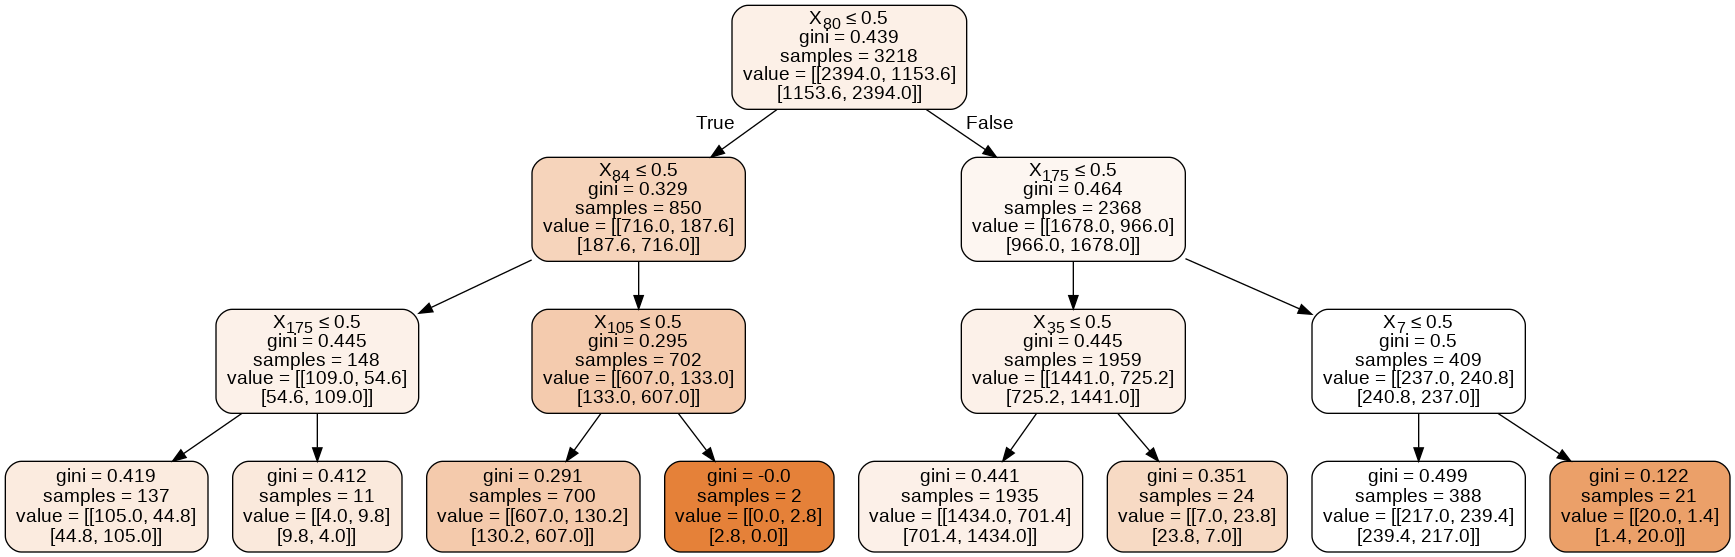

In [23]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
class_names = model.classes_

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                #feature_names = inverted,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [24]:
preds = model.predict(X_test)
print(preds[0])
cross_val_score(model, X_train, y_train, cv=2)

[0 1]


array([0.72405221, 0.72653822])

In [25]:
for i in range(len(X_test)):
  if(X_test[i][80] == 1 and X_test[i][175] == 1 and X_test[i][35] == 1):
    print(preds[i])

In [26]:
model.score(X_test,y_test,)

0.7254658385093168